<a href="https://colab.research.google.com/github/SrTorGonz/Homework-5/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile

# Subir archivo comprimido (ZIP) que contenga Training/ y Testing/
uploaded = files.upload()

# Descomprimir (si el dataset está en ZIP)
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('/content')

train_dir = '/content/Training'  # Ajusta según la estructura exacta
test_dir = '/content/Testing'

Saving archive.zip to archive.zip


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import numpy as np

# 1. Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error GPU:", e)
        print("Reinicia el runtime (Runtime -> Restart runtime)")

# 2. Preprocesamiento sin normalización manual
def enhanced_mri_preprocessing(image):
    image = tf.cast(image, tf.float32)

    # Convertir a RGB si es escala de grises
    if image.shape[-1] == 1:
        image = tf.repeat(image, 3, axis=-1)

    return preprocess_input(image)  # EfficientNet lo maneja internamente

# 3. Generadores de datos
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 4. Modelo base con EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3)
)
base_model.trainable = False  # Congelado al inicio

# 5. Capas personalizadas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(base_model.input, output)

# 6. Compilación inicial
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint('best_model_efficientnet.h5', save_best_only=True)
]

# 8. Fine-tuning
print("\nFine-tuning de capas superiores")
for layer in base_model.layers[:150]:
    layer.trainable = False
for layer in base_model.layers[150:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 9. Entrenamiento
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=callbacks
)

# 10. Evaluación final
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nPrecisión Final con EfficientNetB0: {test_acc:.2%}")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Fine-tuning de capas superiores


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.2999 - loss: 1.4626

179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 717ms/step - accuracy: 0.3001 - loss: 1.4622 - val_accuracy: 0.5622 - val_loss: 1.1622 - learning_rate: 1.0000e-05
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.4651 - loss: 1.2132

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - accuracy: 0.4653 - loss: 1.2129 - val_accuracy: 0.7170 - val_loss: 0.9274 - learning_rate: 1.0000e-05
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6054 - loss: 1.0066

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 538ms/step - accuracy: 0.6055 - loss: 1.0063 - val_accuracy: 0.7735 - val_loss: 0.7422 - learning_rate: 1.0000e-05
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.6961 - loss: 0.8349

179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 532ms/step - accuracy: 0.6962 - loss: 0.8347 - val_accuracy: 0.7941 - val_loss: 0.6104 - learning_rate: 1.0000e-05
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7530 - loss: 0.6847

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 534ms/step - accuracy: 0.7531 - loss: 0.6846 - val_accuracy: 0.8116 - val_loss: 0.5265 - learning_rate: 1.0000e-05
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7788 - loss: 0.5983

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 534ms/step - accuracy: 0.7789 - loss: 0.5981 - val_accuracy: 0.8246 - val_loss: 0.4679 - learning_rate: 1.0000e-05
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8121 - loss: 0.5200

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 537ms/step - accuracy: 0.8121 - loss: 0.5199 - val_accuracy: 0.8246 - val_loss: 0.4400 - learning_rate: 1.0000e-05
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8364 - loss: 0.4601

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - accuracy: 0.8364 - loss: 0.4601 - val_accuracy: 0.8360 - val_loss: 0.4059 - learning_rate: 1.0000e-05
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8632 - loss: 0.4048

179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 527ms/step - accuracy: 0.8632 - loss: 0.4047 - val_accuracy: 0.8436 - val_loss: 0.3954 - learning_rate: 1.0000e-05
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8611 - loss: 0.3982

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 537ms/step - accuracy: 0.8612 - loss: 0.3981 - val_accuracy: 0.8574 - val_loss: 0.3557 - learning_rate: 1.0000e-05
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8693 - loss: 0.3514

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 533ms/step - accuracy: 0.8693 - loss: 0.3514 - val_accuracy: 0.8635 - val_loss: 0.3315 - learning_rate: 1.0000e-05
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8811 - loss: 0.3191

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 529ms/step - accuracy: 0.8811 - loss: 0.3191 - val_accuracy: 0.8757 - val_loss: 0.3043 - learning_rate: 1.0000e-05
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8954 - loss: 0.3010

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 530ms/step - accuracy: 0.8954 - loss: 0.3011 - val_accuracy: 0.8848 - val_loss: 0.2906 - learning_rate: 1.0000e-05
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9039 - loss: 0.2704

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 533ms/step - accuracy: 0.9039 - loss: 0.2704 - val_accuracy: 0.8909 - val_loss: 0.2629 - learning_rate: 1.0000e-05
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9061 - loss: 0.2618

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 532ms/step - accuracy: 0.9061 - loss: 0.2618 - val_accuracy: 0.8993 - val_loss: 0.2449 - learning_rate: 1.0000e-05
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9088 - loss: 0.2601

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 529ms/step - accuracy: 0.9088 - loss: 0.2600 - val_accuracy: 0.9108 - val_loss: 0.2233 - learning_rate: 1.0000e-05
Epoch 17/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9069 - loss: 0.2539

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 528ms/step - accuracy: 0.9070 - loss: 0.2538 - val_accuracy: 0.9214 - val_loss: 0.2141 - learning_rate: 1.0000e-05
Epoch 18/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9332 - loss: 0.2110

179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 536ms/step - accuracy: 0.9332 - loss: 0.2110 - val_accuracy: 0.9245 - val_loss: 0.1922 - learning_rate: 1.0000e-05
Epoch 19/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9258 - loss: 0.1990

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 528ms/step - accuracy: 0.9258 - loss: 0.1991 - val_accuracy: 0.9291 - val_loss: 0.1887 - learning_rate: 1.0000e-05
Epoch 20/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9389 - loss: 0.1866

179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.9389 - loss: 0.1866 - val_accuracy: 0.9344 - val_loss: 0.1696 - learning_rate: 1.0000e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9003 - loss: 0.2558

Precisión Final con EfficientNetB0: 93.44%


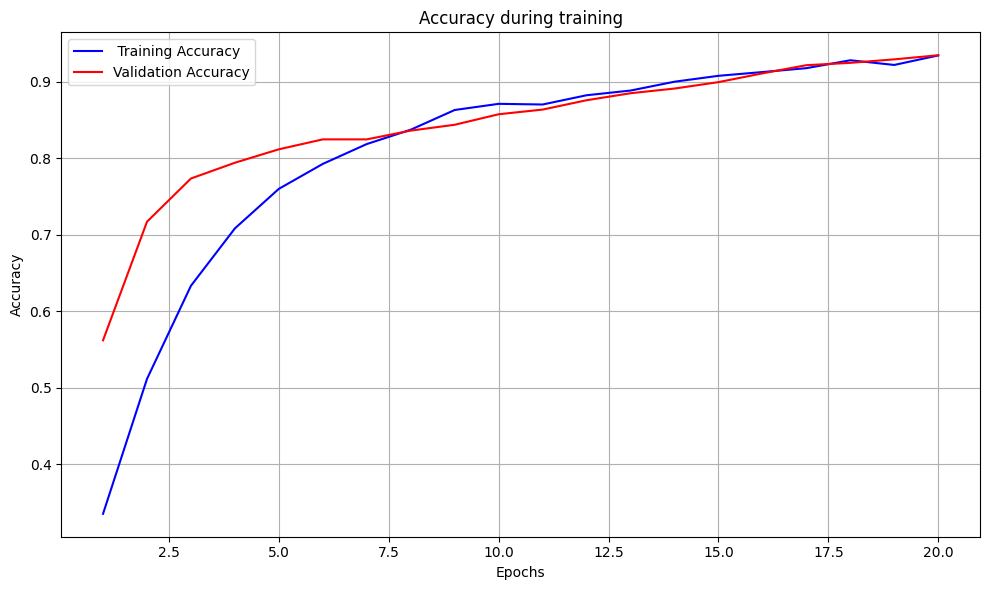

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b-', label=' Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nombres de las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']

Evaluación detallada en el conjunto de test:
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9003 - loss: 0.2558

Exactitud (Accuracy) en test: 0.9344
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9003 - loss: 0.2558
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step
Tamaño de y_true: 1311
Tamaño de y_pred_classes: 1311
Confusion matrix without normalization


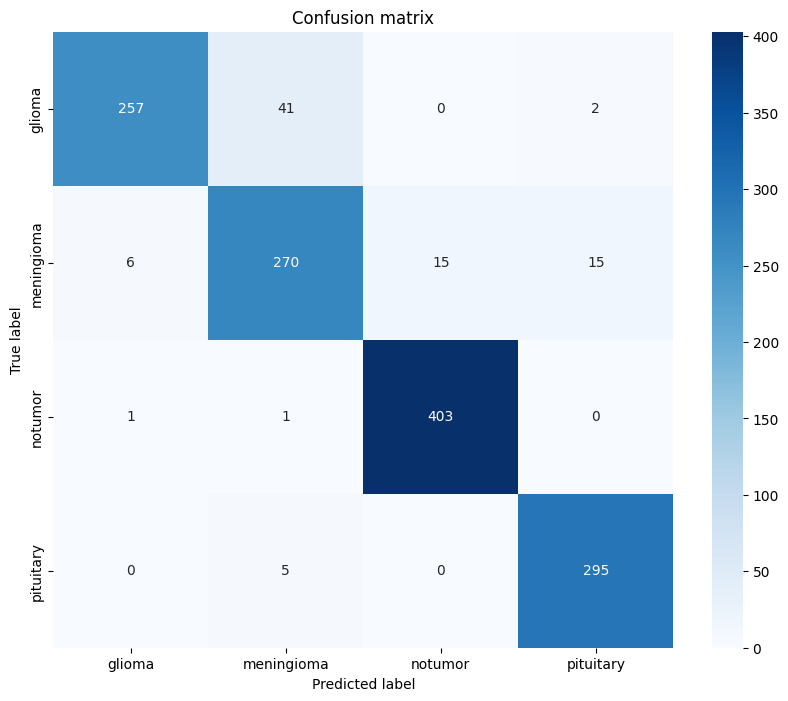


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       0.97      0.86      0.91       300
  meningioma       0.85      0.88      0.87       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Primero obtenemos los nombres de las clases del generador de test
class_names = list(test_generator.class_indices.keys())
print("Nombres de las clases:", class_names)

# 2. Evaluar el modelo en el conjunto de test
print("\nEvaluación detallada en el conjunto de test:")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nExactitud (Accuracy) en test: {test_accuracy:.4f}")

# 3. Predecir las clases para el conjunto de test
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"Tamaño de y_true: {len(y_true)}")
print(f"Tamaño de y_pred_classes: {len(y_pred_classes)}")

# 4. Función para graficar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 5. Graficar matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names, normalize=False)

# 6. Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
